In [1]:
# This line configures matplotlib to show figures embedded in the notebook.
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.cm as cm
from matplotlib.colors import Normalize, rgb2hex
import seaborn as sns
import folium

Source: [CDC: Chronic Disease Indicators](https://www.cdc.gov/cdi/index.html)

In [2]:
usecols = ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1' ]

df = pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", usecols=usecols, dtype={
    'DataValue'                 : 'object',
#    'StratificationCategoryID1' : 'category',
#    'StratificationID1'         : 'category',
#    'DataValueTypeID'           : 'category',
#    'QuestionID'                : 'category',
#    'TopicID'                   : 'category',
})

df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,...,18.0,Overall,Overall,NaN,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,...,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,...,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,...,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,...,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


In [3]:
# Extract location-related attributes into a location table.
dfLocs = df[['LocationID', 'GeoLocation', 'LocationAbbr', 'LocationDesc']]\
    .set_index('LocationID').groupby('LocationID').first()

# Split GeoLocation string into Latitude and Longitude floats
geoLocs = dfLocs['GeoLocation'].str[1:-1].str.split(',', expand=True).astype('float')
geoLocs.columns=['Latitude', 'Longitude']
# Combine Lat/Long into Locations table, and drop unused column.
dfLocs = (pd.concat([dfLocs, geoLocs], axis=1)).drop('GeoLocation', axis=1)
dfLocs.head()

,LocationAbbr,LocationDesc,Latitude,Longitude
LocationID,,,,
1,AL,Alabama,32.840571,-86.631861
2,AK,Alaska,64.845080,-147.722059
4,AZ,Arizona,34.865970,-111.763811
5,AR,Arkansas,34.748650,-92.274491
6,CA,California,37.638640,-121.000000


In [4]:
# Extract topic attributes into a topic table.
dfTopics = df[['TopicID', 'Topic']].groupby('TopicID').first()
dfTopics

,Topic
TopicID,
ALC,Alcohol
ART,Arthritis
AST,Asthma
CAN,Cancer
CKD,Chronic Kidney Disease
COPD,Chronic Obstructive Pulmonary Disease
CVD,Cardiovascular Disease
DIA,Diabetes
DIS,Disability


In [5]:
# Extract question attributes into a question table.
dfQuestions = df[['QuestionID', 'Question']].groupby('QuestionID').first()
dfQuestions

,Question
QuestionID,
ALC10_0,Local authority to regulate alcohol outlet den...
ALC1_1,Alcohol use among youth
ALC1_2,Alcohol use before pregnancy
ALC2_1,Binge drinking prevalence among youth
ALC2_2,Binge drinking prevalence among adults aged >=...
ALC2_3,Binge drinking prevalence among women aged 18-...
ALC3_0,Binge drinking frequency among adults aged >= ...
ALC4_0,Binge drinking intensity among adults aged >= ...
ALC5_1,Heavy drinking among adults aged >= 18 years


In [6]:
# Extract Stratification attributes into a Stratification table.
dfStrats = df[['StratificationID1', 'Stratification1']].groupby('StratificationID1').first()
dfStrats

,Stratification1
StratificationID1,
AIAN,American Indian or Alaska Native
API,Asian or Pacific Islander
ASN,"Asian, non-Hispanic"
BLK,"Black, non-Hispanic"
GENF,Female
GENM,Male
HIS,Hispanic
MRC,"Multiracial, non-Hispanic"
OTH,"Other, non-Hispanic"


In [7]:
# Extract StratificationCategory attributes into a StratificationCategory table.
dfStratCats = df[['StratificationCategoryID1', 'StratificationCategory1']] \
    .groupby('StratificationCategoryID1').first()
dfStratCats

,StratificationCategory1
StratificationCategoryID1,
GENDER,Gender
OVERALL,Overall
RACE,Race/Ethnicity


In [8]:
# Extract DataValueType attributes into a DataValueType table.
dfDataValueTypes = df[['DataValueTypeID', 'DataValueType', 'DataValueUnit']]\
    .groupby('DataValueTypeID').first()
dfDataValueTypes

,DataValueType,DataValueUnit
DataValueTypeID,,
AgeAdjMean,Age-adjusted Mean,Number
AgeAdjPrev,Age-adjusted Prevalence,%
AgeAdjRate,Age-adjusted Rate,"cases per 10,000"
AgeSexRaceAdjRate,"Adjusted by age, sex, race and ethnicity","cases per 1,000,000"
AvgAnnAgeAdjRate,Average Annual Age-adjusted Rate,"per 100,000"
AvgAnnCrdRate,Average Annual Crude Rate,"per 100,000"
AvgAnnNmbr,Average Annual Number,NaN
CommHstLiab,Commercial host (dram shop) liability status f...,NaN
CrdPrev,Crude Prevalence,%


In [9]:
dfData = df.drop(['GeoLocation', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question', 
    'Stratification1', 'StratificationCategory1', 'DataValueType', 'DataValueUnit'], axis=1)
dfData.head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,BRFSS,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,BRFSS,13.0,13.0,NaN,NaN,11.9,14.1,1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,BRFSS,18.2,18.2,NaN,NaN,16.0,20.6,2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,BRFSS,15.6,15.6,NaN,NaN,14.3,16.9,4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,BRFSS,15.0,15.0,NaN,NaN,13.0,17.2,5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


<img src="indicator_11_3.png" alt="Prevalence of depressive disorders among adults
aged ≥18 years with diagnosed diabetes" title="Indicator 11.3" />

In [10]:
# Drill into indicator 11.3
df11_3 = dfData[df['QuestionID'] == 'DIA11_3']
# Strip out NaN data values
df11_3 = df11_3[(df11_3['DataValueAlt'].notnull()) &
                (df11_3['StratificationCategoryID1'] == 'OVERALL') &
                #(df11_3['LocationID'] == 1) &
                #(df11_3['YearStart'] == 2016) &
                (df11_3['DataValueTypeID'] == 'AgeAdjPrev')]
df11_3 = df11_3.groupby('LocationID').mean()
df11_3 = pd.merge(df11_3, dfLocs, left_index=True, right_index=True)
# Strip out U.S. general location (no geo location info)
df11_3 = df11_3[df11_3['Latitude'].notnull()]
df11_3.head()

,YearStart,YearEnd,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,LocationAbbr,LocationDesc,Latitude,Longitude
LocationID,,,,,,,,,
1,2013.5,2013.5,36.450000,29.766667,43.733333,AL,Alabama,32.840571,-86.631861
2,2013.5,2013.5,30.500000,20.000000,43.300000,AK,Alaska,64.845080,-147.722059
4,2013.5,2013.5,35.833333,27.966667,44.566667,AZ,Arizona,34.865970,-111.763811
5,2013.5,2013.5,38.216667,29.500000,47.766667,AR,Arkansas,34.748650,-92.274491
6,2013.5,2013.5,19.583333,14.716667,25.566667,CA,California,37.638640,-121.000000


In [11]:
norm = Normalize(df11_3['DataValueAlt'].min(), df11_3['DataValueAlt'].max())

fmap = folium.Map(location=[48, -102], zoom_start=3)
for loc in df11_3.iterrows():
    val = loc[1]['DataValueAlt']
    color = rgb2hex(cm.OrRd(norm(val)))
    
    folium.CircleMarker([loc[1]['Latitude'], loc[1]['Longitude']], 
                    popup="%s: %0.02f%%" % (loc[1]['LocationDesc'], val), 
                    radius=0.25*val,
                    color=color,
                    fill=color).add_to(fmap)
fmap

QuestionID,TopicID,YearStart,YearEnd,LocationID,StratificationID1,DIA10_0,DIA11_1,DIA11_2,DIA11_3,DIA12_1,DIA12_2,DIA13_1,DIA13_2,DIA2_1,DIA5_0,DIA6_0,DIA7_0,DIA8_0
0,DIA,2011,2011,1,GENF,50.1,64.8,70.3,38.9,41.9,66.9,40.5,77.1,11.6,61.4,61.9,59.9,NaN
1,DIA,2011,2011,1,GENM,71.8,67.0,74.6,42.0,40.5,69.6,34.2,81.4,10.5,73.5,77.1,64.0,NaN
2,DIA,2011,2011,2,GENF,65.2,52.3,79.4,56.6,33.8,56.4,58.8,75.4,8.5,50.6,42.0,59.3,NaN
3,DIA,2011,2011,2,GENM,67.1,69.8,50.4,NaN,11.8,NaN,25.6,NaN,8.3,86.9,65.4,74.1,NaN
4,DIA,2011,2011,4,GENF,47.7,71.2,57.6,45.9,34.4,60.7,44.3,80.0,8.3,60.2,64.3,55.8,NaN


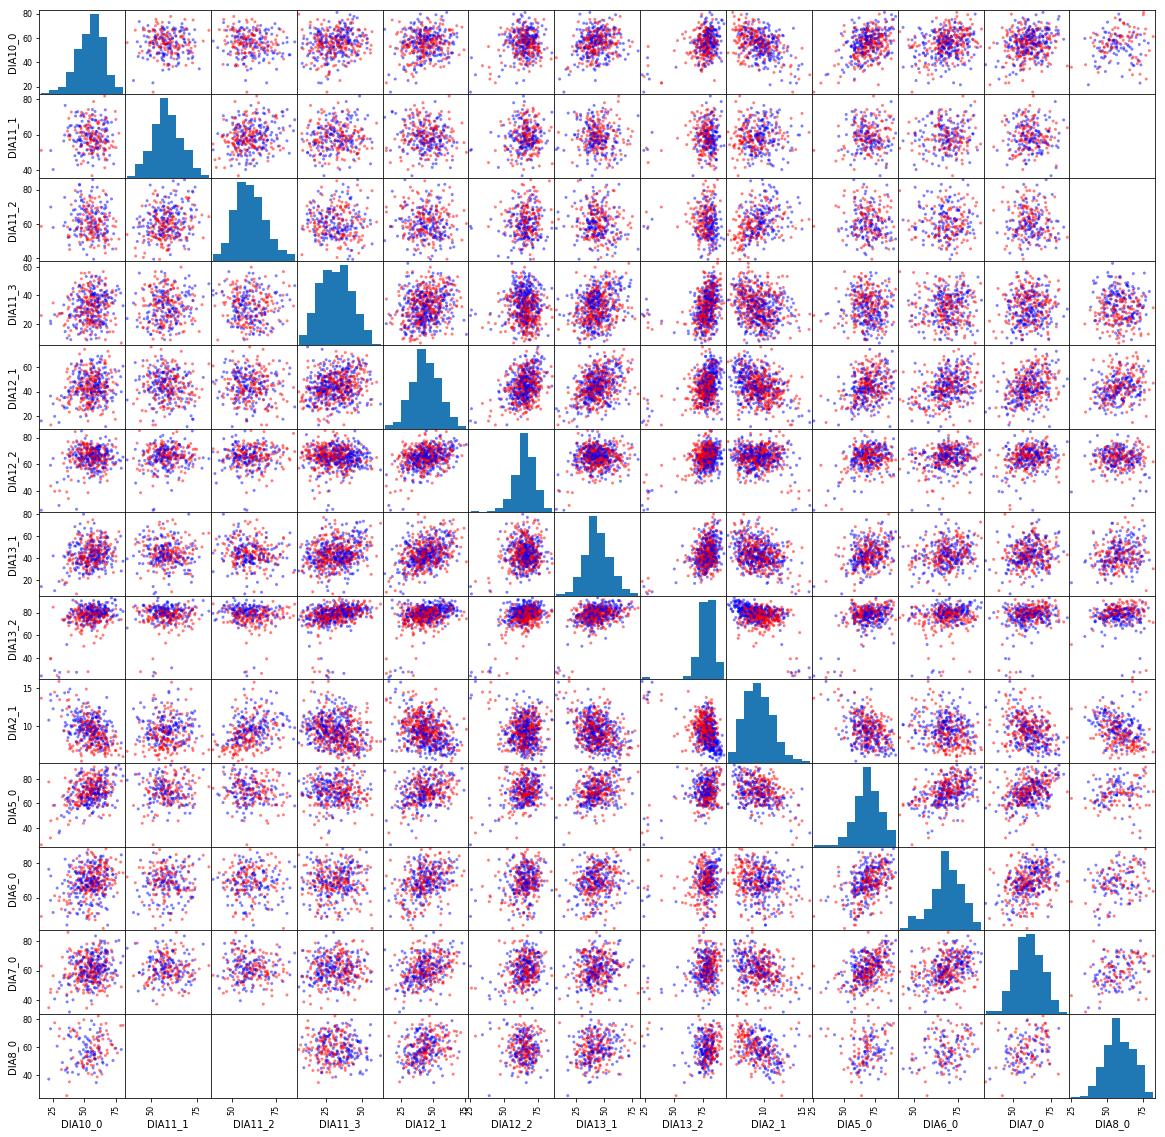

In [12]:
dfGender = dfData[(dfData["TopicID"] == 'DIA') &
                (dfData['DataValueTypeID'] == 'AgeAdjPrev') &
                 dfData['DataValueAlt'].notnull() &
#                (dfData['LocationID'] == 1) &
#                (dfData['YearStart'] == 2016) &
                (dfData['StratificationCategoryID1'] == 'GENDER')]

pivot_index = ['TopicID', 'YearStart', 'YearEnd', 'LocationID', 'StratificationID1']
dfGender = pd.pivot_table(dfGender, index = pivot_index, columns = 'QuestionID',  values = 'DataValueAlt').reset_index()
dfGenderIndicators = dfGender.drop(pivot_index,axis=1)

genderColors=['red', 'blue']
m = pd.plotting.scatter_matrix(dfGenderIndicators, c=genderColors, figsize=(20, 20))
dfGender.head()


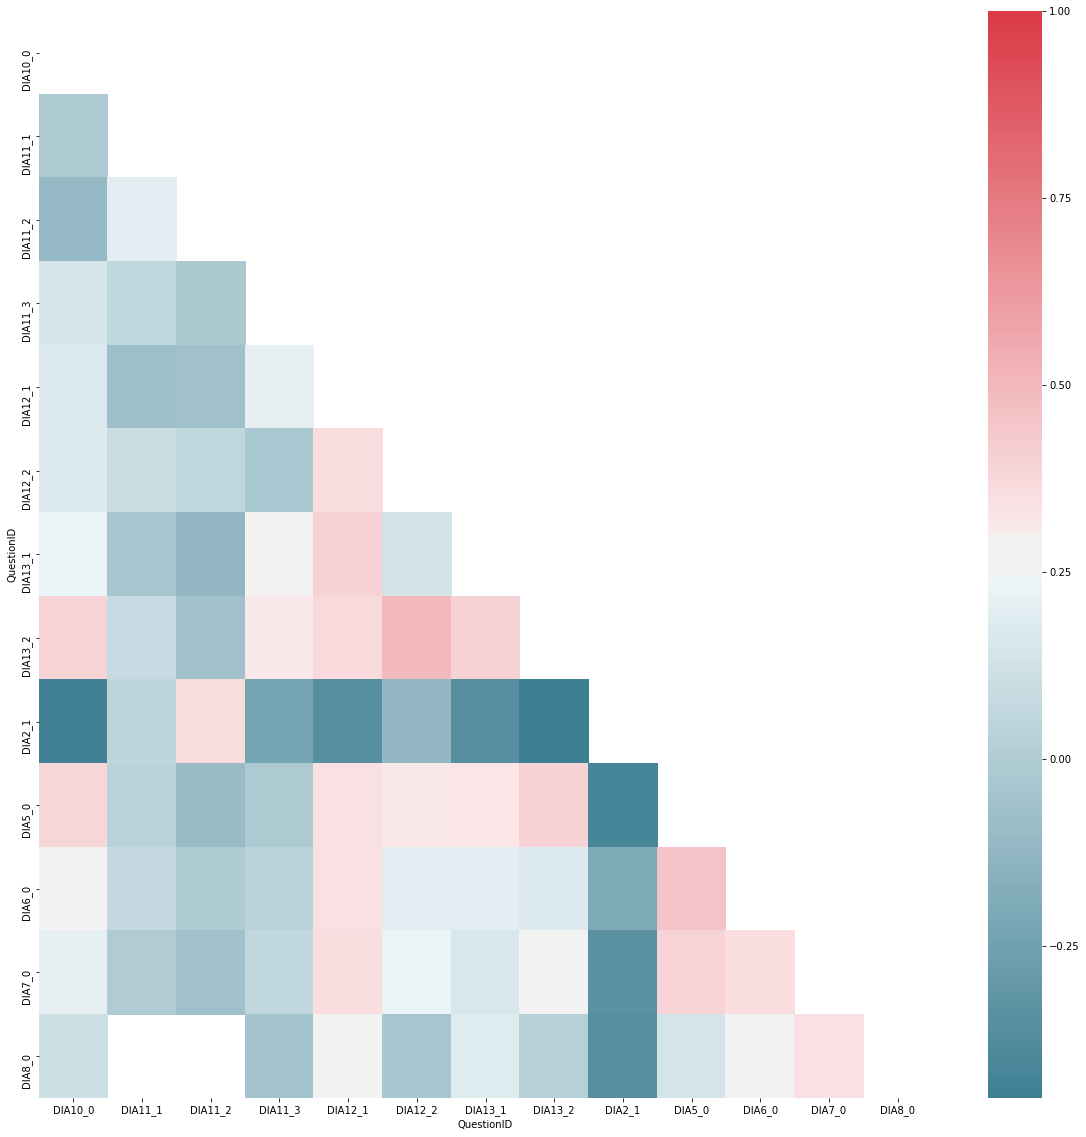

In [13]:
corr = dfGenderIndicators.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))     
h = sns.heatmap(corr, mask=mask, cmap=corr_cmap, ax=ax)
h

QuestionID,TopicID,YearStart,YearEnd,LocationID,StratificationID1,DIA10_0,DIA11_1,DIA11_2,DIA11_3,DIA12_1,DIA12_2,DIA13_1,DIA13_2,DIA2_1,DIA5_0,DIA6_0,DIA7_0,DIA8_0
0,DIA,2011,2011,1,BLK,53.4,53.7,74.7,29.9,35.0,56.9,39.1,67.6,14.8,73.6,63.9,63.1,NaN
1,DIA,2011,2011,1,HIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,NaN
2,DIA,2011,2011,1,OTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.8,NaN,NaN,NaN,NaN
3,DIA,2011,2011,1,WHT,64.1,65.1,72.3,48.9,46.4,72.0,31.7,83.2,9.9,64.5,73.5,63.2,NaN
4,DIA,2011,2011,2,OTH,60.6,65.0,80.0,NaN,NaN,NaN,NaN,NaN,9.6,77.0,NaN,80.4,NaN


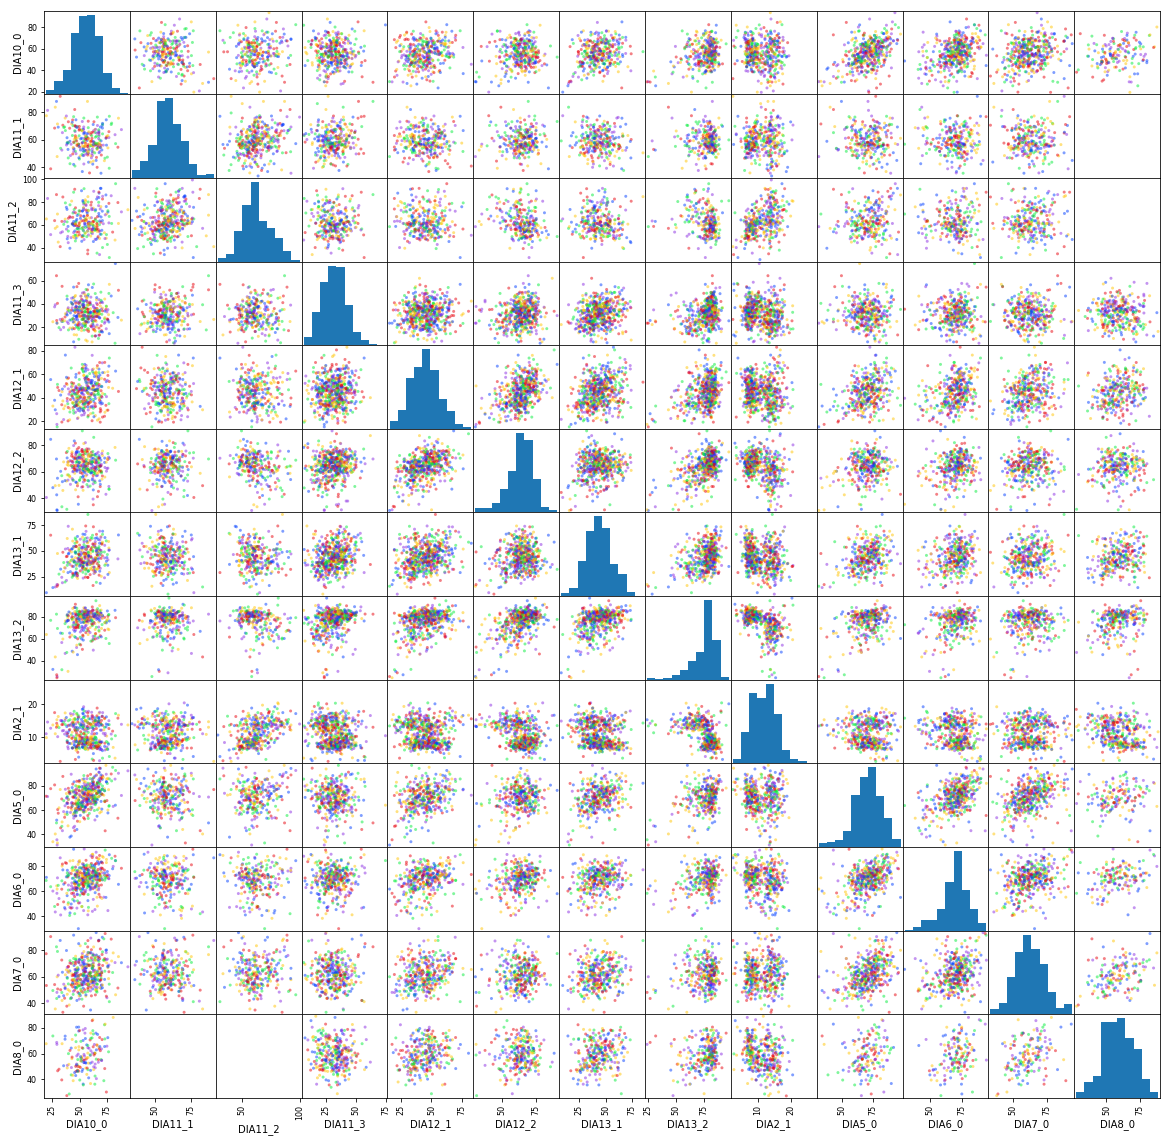

In [14]:
dfRace = dfData[(dfData["TopicID"] == 'DIA') &
                (dfData['DataValueTypeID'] == 'AgeAdjPrev') &
                 dfData['DataValueAlt'].notnull() &
#                (dfData['LocationID'] == 1) &
#                (dfData['YearStart'] == 2016) &
                (dfData['StratificationCategoryID1'] == 'RACE')]

pivot_index = ['TopicID', 'YearStart', 'YearEnd', 'LocationID', 'StratificationID1']
dfRace = pd.pivot_table(dfRace, index = pivot_index, columns = 'QuestionID',  values = 'DataValueAlt').reset_index()
dfRaceIndicators = dfRace.drop(pivot_index,axis=1)

raceColors = sns.color_palette("bright", len(dfRace['StratificationID1'].value_counts().index))
m = pd.plotting.scatter_matrix(dfRaceIndicators, c=raceColors, figsize=(20, 20))
dfRace.head()

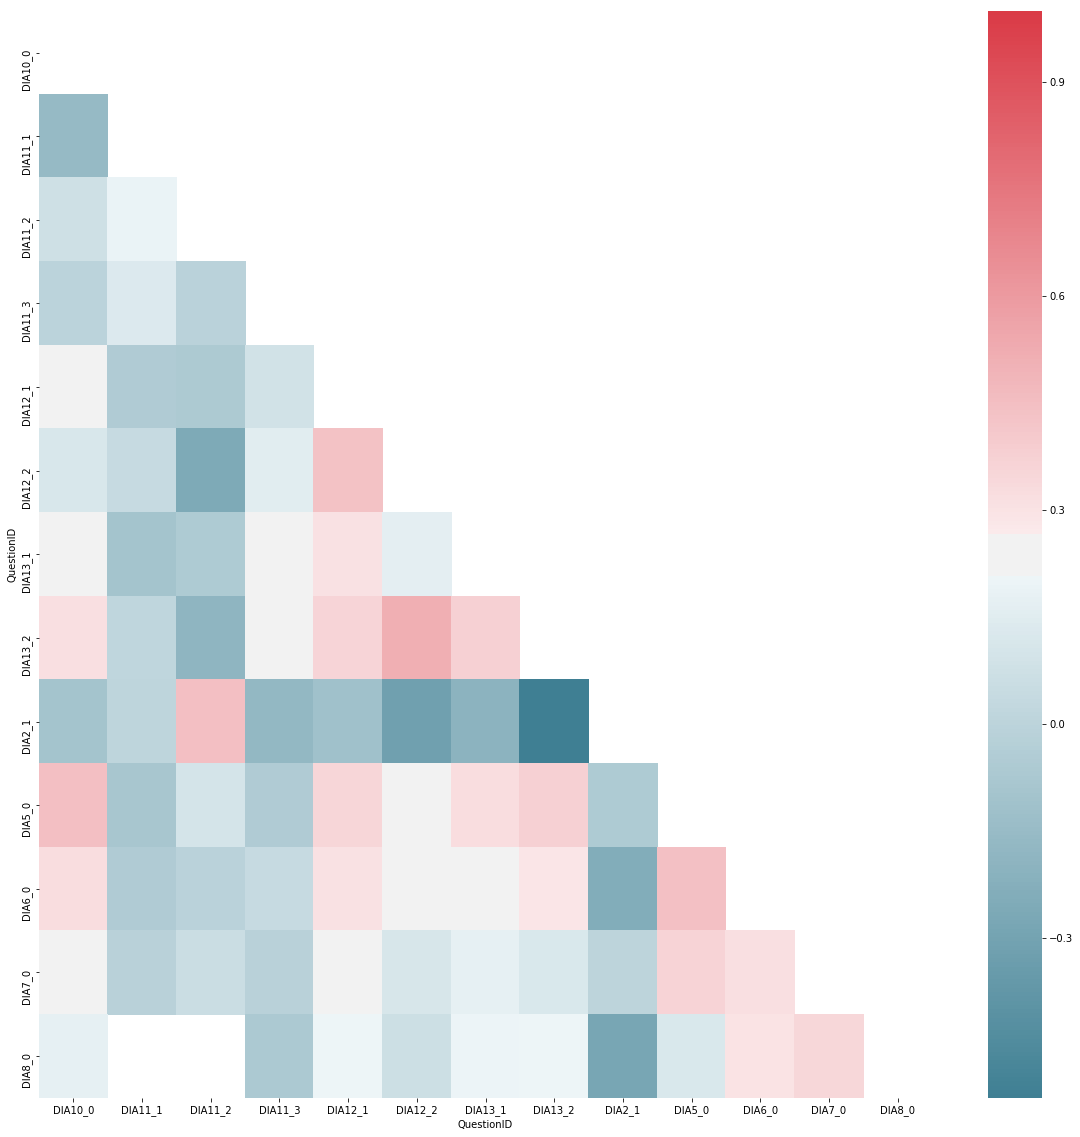

In [15]:
corr = dfRaceIndicators.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))     
h = sns.heatmap(corr, mask=mask, cmap=corr_cmap, ax=ax)
h